In [16]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential as Seq
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np
from torch.utils.data import Dataset

### Graph Network Definition
class GraphNetwork(MessagePassing):
    def __init__(self, in_channels, hidden_dim, msg_dim, out_channels, aggr='add'):
        super(GraphNetwork, self).__init__(aggr=aggr)

        self.message_net = Seq(
            Linear(2 * in_channels, hidden_dim),
            ReLU(),
            Linear(hidden_dim, msg_dim)
        )

        self.update_net = Seq(
            Linear(msg_dim + in_channels, hidden_dim),
            ReLU(),
            Linear(hidden_dim, out_channels)
        )

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        edge_features = torch.cat([x_i, x_j], dim=1)
        return self.message_net(edge_features)

    def aggregate(self, inputs, index, dim_size=None):
        out = torch.zeros(dim_size, inputs.size(1), device=inputs.device)
        out.scatter_add_(0, index.unsqueeze(-1).expand_as(inputs), inputs)
        return out

    def update(self, aggr_out, x):
        combined = torch.cat([x, aggr_out], dim=1)
        return self.update_net(combined)


### N-body Graph Network
class NbodyGraph(GraphNetwork):
    def __init__(self, in_channels, hidden_dim, msg_dim, out_channels, dt, nt, ndim, aggr='add'):
        super(NbodyGraph, self).__init__(in_channels, hidden_dim, msg_dim, out_channels, aggr=aggr)
        self.dt = dt
        self.nt = nt
        self.ndim = ndim

    def simple_derivative(self, g):
        return self.propagate(g.edge_index, x=g.x)

    def loss(self, g):
        pred_dv_dt = self.simple_derivative(g)[:, self.ndim:]
        return torch.sum(torch.abs(g.y - pred_dv_dt))


### Graph Utilities
def connect_all(num_nodes):
    indices = torch.combinations(torch.arange(num_nodes), with_replacement=False).T
    return torch.cat([indices, indices.flip(0)], dim=1)  # Bidirectional edges


def prepare_graph_from_simulation(simulation_index=0, time_index=0):
    x_np = positions_velocities[simulation_index, time_index]
    x = torch.tensor(x_np, dtype=torch.float32).clone()

    edge_index = connect_all(num_bodies)

    y_np = accelerations[simulation_index, time_index]
    y = torch.tensor(y_np, dtype=torch.float32).clone()

    return Data(x=x, edge_index=edge_index, y=y)


### Dataset Loader
class NBodyDataset(Dataset):
    def __init__(self, positions_velocities, accelerations):
        self.positions_velocities = positions_velocities
        self.accelerations = accelerations
        self.num_simulations, self.num_timesteps, self.num_bodies, _ = positions_velocities.shape

    def __len__(self):
        return self.num_simulations

    def __getitem__(self, index):
        sim_idx = index // self.num_timesteps
        time_idx = index % self.num_timesteps

        x_np = self.positions_velocities[sim_idx, time_idx]
        x = torch.tensor(x_np, dtype=torch.float32).clone()

        edge_index = connect_all(self.num_bodies)

        y_np = self.accelerations[sim_idx, time_idx]
        y = torch.tensor(y_np, dtype=torch.float32).clone()

        return Data(x=x, edge_index=edge_index, y=y)


### Training Function
import torch.optim as optim

def train(model, dataloader, epochs=10, lr=0.001, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.L1Loss()

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for batch in dataloader:
            batch = batch.to(device)  # Move batch to GPU/CPU
            optimizer.zero_grad()
            pred = model(batch.x, batch.edge_index)
            loss = loss_fn(pred, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/30:.6f}")


if __name__ == "__main__":
    # Load dataset
    loaded_data = np.load("../../Data/nbody_simulation.npz")
    positions_velocities = loaded_data["data"]
    accelerations = loaded_data["accelerations"]

    # Extract dataset values
    times = loaded_data["times"]
    num_bodies = int(loaded_data["num_bodies"])
    num_timesteps = int(loaded_data["num_timesteps"])
    spatial_dim = int(loaded_data["spatial_dim"])
    
    # Prepare first graph for model initialization
    test_graph = prepare_graph_from_simulation(0, 0)

    # Initialize model
    model = NbodyGraph(
        in_channels=test_graph.x.shape[1], 
        hidden_dim=32, 
        msg_dim=16, 
        out_channels=spatial_dim,
        dt=0.01, 
        nt=num_timesteps, 
        ndim=spatial_dim
    )

    # Load dataset & DataLoader
    dataset = NBodyDataset(positions_velocities, accelerations)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Train the model
#    train(model, dataloader, epochs=20, device='cuda' if torch.cuda.is_available() else 'cpu')
    train(model, dataloader, epochs=20, device='cpu')
    # Test forward pass
    test_graph = test_graph.to('cuda' if torch.cuda.is_available() else 'cpu')
    output = model(test_graph.x, test_graph.edge_index)

    print("Predicted accelerations (dv/dt):")
    print(output)


Epoch 1/20, Loss: 388.162150
Epoch 2/20, Loss: 311.643642
Epoch 3/20, Loss: 273.479484
Epoch 4/20, Loss: 248.154852
Epoch 5/20, Loss: 233.423958
Epoch 6/20, Loss: 216.538566
Epoch 7/20, Loss: 196.152454
Epoch 8/20, Loss: 180.074753
Epoch 9/20, Loss: 169.330274
Epoch 10/20, Loss: 159.315961
Epoch 11/20, Loss: 152.362872
Epoch 12/20, Loss: 148.670233
Epoch 13/20, Loss: 144.247958
Epoch 14/20, Loss: 142.203022
Epoch 15/20, Loss: 138.626247
Epoch 16/20, Loss: 136.669906
Epoch 17/20, Loss: 133.372509
Epoch 18/20, Loss: 129.683293
Epoch 19/20, Loss: 127.227702
Epoch 20/20, Loss: 123.901723
Predicted accelerations (dv/dt):
tensor([[ 7.3844,  4.2638],
        [-9.4549, -2.8637],
        [-0.4406,  0.0754],
        [-0.2637, -0.4438]], grad_fn=<AddmmBackward0>)


In [22]:

    print(test_graph.x.shape)
    print(test_graph.edge_index.shape)
    output = model(test_graph.x, test_graph.edge_index)

    print("Predicted accelerations (dv/dt):")
    print(output)

torch.Size([4, 6])
torch.Size([2, 12])
Predicted accelerations (dv/dt):
tensor([[ 7.3844,  4.2638],
        [-9.4549, -2.8637],
        [-0.4406,  0.0754],
        [-0.2637, -0.4438]], grad_fn=<AddmmBackward0>)


(10000, 2500, 4, 6)


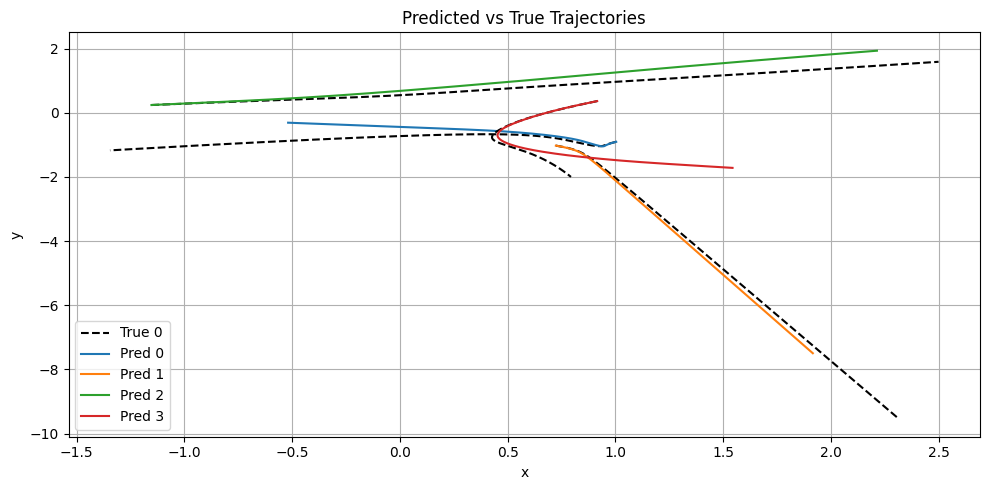

In [29]:
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate_and_plot(model, positions_velocities, accelerations, spatial_dim, simulation_index=0, device='cpu'):
    model.eval()
    model = model.to(device)

    num_timesteps = positions_velocities.shape[1]
    num_bodies = positions_velocities.shape[2]
    dt = model.dt

    # Initialize position and velocity
    x_pred = torch.tensor(positions_velocities[simulation_index, 0], dtype=torch.float32).to(device)
    trajectory_pred = [x_pred[:, :spatial_dim].cpu().numpy()]
    constants = x_pred[:, 2 * spatial_dim:]  # shape: [num_bodies, 2]

    # Simulate forward
    for t in range(1, 200): #num_timesteps):
        edge_index = connect_all(num_bodies).to(device)
        acc = model(x_pred, edge_index)  # Predict accelerations

        pos = x_pred[:, :spatial_dim]
        vel = x_pred[:, spatial_dim:2*spatial_dim]

        # Euler integration step
        vel_next = vel + acc * dt
        pos_next = pos + vel_next * dt
        x_pred = torch.cat([pos_next, vel_next, constants], dim=1)
        trajectory_pred.append(pos_next.cpu().numpy())

    # Convert to numpy arrays
    trajectory_pred = np.stack(trajectory_pred)
    trajectory_true = positions_velocities[simulation_index, :, :, :spatial_dim]

    # Plot only first two spatial dimensions
    plt.figure(figsize=(10, 5))
    for i in range(num_bodies):
        plt.plot(trajectory_true[:, i, 0], trajectory_true[:, i, 1], 'k--', label=f'True {i}' if i == 0 else "")
        plt.plot(trajectory_pred[:, i, 0], trajectory_pred[:, i, 1], label=f'Pred {i}')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Predicted vs True Trajectories")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
print(positions_velocities.shape)
evaluate_and_plot(model, positions_velocities, accelerations, spatial_dim=2, simulation_index=0, device='cpu')


/tmp/ipykernel_309175/139983067.py:34: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((pred_pos - true_pos) ** 2))
/home/yi260/.conda/envs/final/lib/python3.10/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


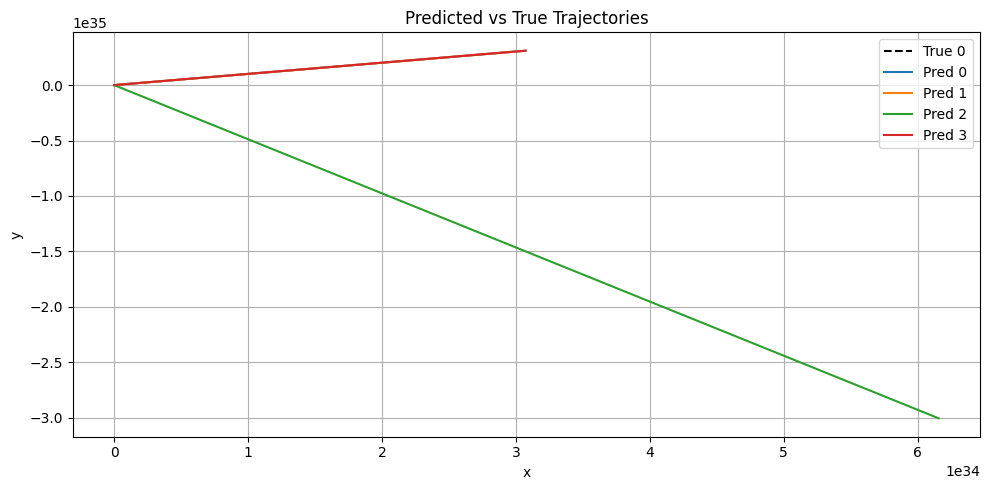

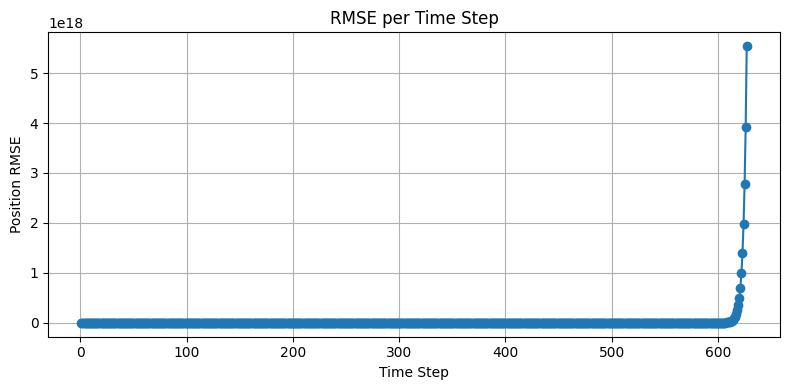

Average RMSE: nan


In [31]:
import matplotlib.pyplot as plt
import numpy as np

@torch.no_grad()
def evaluate_and_plot(model, positions_velocities, accelerations, spatial_dim, simulation_index=0, device='cpu'):
    model.eval()
    model = model.to(device)

    num_timesteps = positions_velocities.shape[1]
    num_bodies = positions_velocities.shape[2]
    dt = model.dt

    x_pred = torch.tensor(positions_velocities[simulation_index, 0], dtype=torch.float32).to(device)
    trajectory_pred = [x_pred[:, :spatial_dim].cpu().numpy()]
    rmse_list = []

    for t in range(1, num_timesteps):
        edge_index = connect_all(num_bodies).to(device)
        acc = model(x_pred, edge_index)

        pos = x_pred[:, :spatial_dim]
        vel = x_pred[:, spatial_dim:2 * spatial_dim]
        constants = x_pred[:, 2 * spatial_dim:]

        vel_next = vel + acc * dt
        pos_next = pos + vel_next * dt
        x_pred = torch.cat([pos_next, vel_next, constants], dim=1)

        trajectory_pred.append(pos_next.cpu().numpy())

        # Compute RMSE at this time step
        true_pos = positions_velocities[simulation_index, t, :, :spatial_dim]
        pred_pos = pos_next.cpu().numpy()
        rmse = np.sqrt(np.mean((pred_pos - true_pos) ** 2))
        rmse_list.append(rmse)

    # Convert to numpy arrays
    trajectory_pred = np.stack(trajectory_pred)
    trajectory_true = positions_velocities[simulation_index, :, :, :spatial_dim]

    # Plot trajectories
    plt.figure(figsize=(10, 5))
    for i in range(num_bodies):
        plt.plot(trajectory_true[:, i, 0], trajectory_true[:, i, 1], 'k--', label=f'True {i}' if i == 0 else "")
        plt.plot(trajectory_pred[:, i, 0], trajectory_pred[:, i, 1], label=f'Pred {i}')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Predicted vs True Trajectories")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot RMSE over time
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_timesteps), rmse_list, marker='o')
    plt.title("RMSE per Time Step")
    plt.xlabel("Time Step")
    plt.ylabel("Position RMSE")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rmse_list
rmse_per_step = evaluate_and_plot(model, positions_velocities, accelerations, spatial_dim=2, simulation_index=0, device='cpu')
print("Average RMSE:", np.mean(rmse_per_step))


In [ ]:
# create simulation data
import simulate

# Number of simulations to run (it's fast, don't worry):
ns = 100
# Potential (see below for options)
sim = 'spring'
# Number of nodes
n = 4
# Dimension
dim = 2
# Number of time steps
nt = 10000

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
 {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
 {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
]

#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
print('Running on', title)

from simulate import SimulationDataset
s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
# Update this to your own dataset, or regenerate:
base_str = './'
data_str = title
s.simulate(ns)

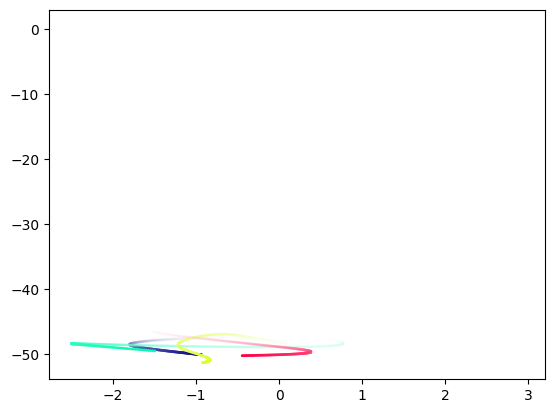

In [4]:
s.plot(0, animate=True, plot_size=False)

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... one
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=545146 sha256=d7ea2dd577c912673af4bf3dfc7cc23cc723170c3065fafa7c93d866f0cc71ff
  Stored in directory: /home/yi260/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... one
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1119715 sha256=3b93d4735f95f98b0fdee100bb1d5dd93ccbf3f6060e35d77922c61f58b0a2e0
  Stored in directory: /home/yi260/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built torch-sparse


In [ ]:
# setup model
import pytorch



model = 

